In [111]:
import pandas as pd
import warnings
from datetime import date, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.metrics import f1_score,recall_score,classification_report,ConfusionMatrixDisplay, mean_squared_error,roc_auc_score,accuracy_score,precision_score, mean_absolute_error, r2_score, confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from dmba import classificationSummary



In [112]:
traindmg = pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\traindemographics.csv')
trainpvln= pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\trainprevloans.csv')
trainperf = pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\trainperf.csv')

In [113]:
testdmg = pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\testdemographics.csv')
testpvln= pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\testprevloans.csv')
testperf = pd.read_csv(r'C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\testperf.csv')

In [114]:
traindmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


In [115]:
traindmg.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [116]:
print(traindmg.isnull().sum())


customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64


In [117]:
traindmg['employment_status_clients'].replace(np.nan, "Unknown", inplace = True)
testdmg['employment_status_clients'].replace(np.nan, "Unknown", inplace = True)
#raindmg['level_of_education_clients'].replace(np.nan, "Unknown", inplace = True)
#testdmg['level_of_education_clients'].replace(np.nan, "Unknown", inplace = True)

In [118]:
train_demo_cols = traindmg[['customerid']].copy(deep = True)
train_demo_cols.head()

,customerid
0,8a858e135cb22031015cbafc76964ebd
1,8a858e275c7ea5ec015c82482d7c3996
2,8a858e5b5bd99460015bdc95cd485634
3,8a858efd5ca70688015cabd1f1e94b55
4,8a858e785acd3412015acd48f4920d04


In [119]:
def demo_features(traindmg):
    train_demo_cols = traindmg[['customerid']].copy(deep = True)
    train_demo_cols['age'] =  date.today().year - pd.DatetimeIndex(traindmg['birthdate']).year
    train_demo_cols = pd.concat([train_demo_cols, pd.get_dummies(traindmg['bank_account_type'], 'bank_account_type')], axis=1)
    train_demo_cols = pd.concat([train_demo_cols, pd.get_dummies(traindmg['employment_status_clients'], 'employment_status_clients')], axis=1)
    #train_demo_cols = pd.concat([train_demo_cols, pd.get_dummies(traindmg['level_of_education_clients'], 'level_of_education_clients')], axis=1)
    return train_demo_cols

train_demo_cols = demo_features(traindmg)

In [120]:
print(trainpvln.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB
None


In [121]:
print(trainpvln.isnull().sum())

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64


In [122]:
trainpvln.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [123]:
 train_prevloan_cols = trainpvln.copy(deep = True)
train_prevloan_cols.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [124]:
trainpvln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [125]:
def prevloan_features(trainpvln):
    train_prevloan_cols = trainpvln.copy(deep = True)

    train_prevloan_cols['firstrepaiddate'] = pd.to_datetime(train_prevloan_cols['firstrepaiddate']) 
    train_prevloan_cols['firstduedate'] = pd.to_datetime(train_prevloan_cols['firstduedate'])
    train_prevloan_cols['missed_first_due_date'] = train_prevloan_cols['firstrepaiddate'].dt.date > train_prevloan_cols['firstduedate'].dt.date

    train_prevloan_cols['closeddate'] = pd.to_datetime(train_prevloan_cols['closeddate'])
    train_prevloan_cols['approveddate'] = pd.to_datetime(train_prevloan_cols['approveddate'])
    train_prevloan_cols['creationdate'] = pd.to_datetime(train_prevloan_cols['creationdate'])
  
    train_prevloan_cols['termdays_td'] = pd.to_timedelta(train_prevloan_cols['termdays'], unit= 'days')
    train_prevloan_cols['finalduedate'] = train_prevloan_cols['approveddate'] + train_prevloan_cols['termdays_td']
    train_prevloan_cols['closed_loan_late'] = train_prevloan_cols['closeddate'].dt.date > train_prevloan_cols['finalduedate'].dt.date
    train_prevloan_cols['repayment_time'] = (train_prevloan_cols['firstrepaiddate'] - train_prevloan_cols['firstduedate']).dt.days
    train_prevloan_cols['loan_duration_days'] = (train_prevloan_cols['closeddate'] - train_prevloan_cols['creationdate']).dt.days
    train_prevloan_cols['days_since_last_loan'] = (pd.to_datetime('today') - train_prevloan_cols['approveddate']).dt.days
    train_prevloan_cols['first_due_duration_days'] = (train_prevloan_cols['firstduedate'] - train_prevloan_cols['approveddate']).dt.days
    train_prevloan_cols['previous_loans'] = train_prevloan_cols['loannumber'] - 1
    train_prevloan_cols['is_referred'] = train_prevloan_cols['referredby'].notnull().astype(int)
    

    
    train_prevloan_cols_grp = train_prevloan_cols[['customerid','systemloanid','loanamount','missed_first_due_date', 'closed_loan_late', 'termdays','repayment_time','loan_duration_days','days_since_last_loan','first_due_duration_days','previous_loans','is_referred']]

    train_prevloan_cols_grp_cols = train_prevloan_cols_grp.groupby('customerid', as_index = False).agg({'systemloanid':'count','loanamount': 'mean','missed_first_due_date': 'sum', 'closed_loan_late':'sum', 'termdays':'mean','repayment_time':'mean','loan_duration_days':'mean','days_since_last_loan':'mean','first_due_duration_days':'mean','previous_loans':'mean','is_referred':'mean'})
    train_prevloan_cols_grp_cols.rename( columns = {'systemloanid': 'total_loans','loanamount': 'avg_loanamount', 'missed_first_due_date': 'total_missed_first_due_date', 'closed_loan_late':'total_closed_loan_late', 'termdays':'average_termdays','repayment_time':'average_repayment_time','loan_duration_days':'average_loan_duration_days','days_since_last_loan':'average_days_since_last_loan','first_due_duration_days':'average_days_first_due_duration_days','previous_loans':'average_previous_loans','is_referred':'average_is_referred'}   , inplace = True)
    return train_prevloan_cols_grp_cols

train_prevloan_cols_grp_cols = prevloan_features(trainpvln)
train_prevloan_cols_grp_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   customerid                            4359 non-null   object 
 1   total_loans                           4359 non-null   int64  
 2   avg_loanamount                        4359 non-null   float64
 3   total_missed_first_due_date           4359 non-null   int64  
 4   total_closed_loan_late                4359 non-null   int64  
 5   average_termdays                      4359 non-null   float64
 6   average_repayment_time                4359 non-null   float64
 7   average_loan_duration_days            4359 non-null   float64
 8   average_days_since_last_loan          4359 non-null   float64
 9   average_days_first_due_duration_days  4359 non-null   float64
 10  average_previous_loans                4359 non-null   float64
 11  average_is_referr

In [78]:
print(trainperf.info())
trainperf.head()
#print(trainperf.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB
None


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [79]:
trainperf['good_bad_ind'] = np.where(trainperf['good_bad_flag']=="Good", 1, 0)
trainperf['good_bad_ind'].value_counts()

good_bad_ind
1    3416
0     952
Name: count, dtype: int64

In [80]:
def perf_features(trainperf, train = True):
    
    if train:
        trainperf['good_bad_ind'] = np.where(trainperf['good_bad_flag']=="Good", 1, 0)
        train_perf_cols = trainperf[['customerid', 'loannumber', 'loanamount', 'termdays','totaldue','good_bad_ind']]
        train_perf_cols['loan_to_totaldue_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['totaldue']
        train_perf_cols['loan_to_termdays_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['termdays'] 
    else:
        train_perf_cols = trainperf[['customerid', 'loannumber', 'loanamount', 'termdays','totaldue']]
        train_perf_cols['loan_to_totaldue_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['totaldue']
        train_perf_cols['loan_to_termdays_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['termdays']
      
    return train_perf_cols

train_perf_cols = perf_features(trainperf, train = True)

C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\2782998248.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_perf_cols['loan_to_totaldue_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['totaldue']
C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\2782998248.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_perf_cols['loan_to_termdays_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['termdays']


In [81]:
def merge_sets(train_perf_cols, train_demo_cols, train_prevloan_cols_grp_cols):
    
    train = pd.merge(train_perf_cols, train_demo_cols, how ='inner', left_on='customerid', right_on='customerid')
    train = pd.merge(train, train_prevloan_cols_grp_cols, how ='inner', left_on='customerid', right_on='customerid')
    return train

train = merge_sets(train_perf_cols, train_demo_cols, train_prevloan_cols_grp_cols)
train

,customerid,loannumber,loanamount,termdays,totaldue,good_bad_ind,loan_to_totaldue_ratio,loan_to_termdays_ratio,age,bank_account_type_Current,...,avg_loanamount,total_missed_first_due_date,total_closed_loan_late,average_termdays,average_repayment_time,average_loan_duration_days,average_days_since_last_loan,average_days_first_due_duration_days,average_previous_loans,average_is_referred
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,30,34500.0,1,0.869565,1000.000000,52,False,...,18181.818182,3,4,30.0,-0.909091,29.545455,2771.727273,29.727273,5.0,0.0
1,8a8588f35438fe12015444567666018e,7,20000.0,15,22250.0,1,0.898876,1333.333333,40,False,...,10000.000000,1,1,17.5,0.833333,18.166667,2725.666667,17.000000,2.5,0.0
2,8a85890754145ace015429211b513e16,3,10000.0,15,11500.0,1,0.869565,666.666667,47,False,...,10000.000000,2,2,22.5,7.500000,31.500000,2624.500000,23.000000,0.5,0.0
3,8a858970548359cc0154883481981866,9,40000.0,30,44000.0,1,0.909091,1333.333333,38,False,...,18750.000000,0,0,37.5,-3.125000,27.000000,2740.750000,29.500000,3.5,0.0
4,8a858e095c59b91b015c5e5cea3719bc,3,10000.0,30,13000.0,1,0.769231,333.333333,35,False,...,10000.000000,0,0,22.5,-2.500000,19.500000,2616.500000,21.500000,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858e395cb1d4d9015cb2115b1d13d7,2,10000.0,15,11500.0,0,0.869565,666.666667,45,False,...,10000.000000,0,1,15.0,0.000000,16.000000,2607.000000,16.000000,0.0,1.0
3268,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,30,13000.0,0,0.769231,333.333333,35,False,...,10000.000000,0,0,30.0,-4.000000,26.000000,2593.000000,30.000000,0.0,0.0
3269,8a858f365b2547f3015b284597147c94,3,10000.0,15,11500.0,0,0.869565,666.666667,35,False,...,10000.000000,1,1,15.0,8.000000,23.000000,2666.000000,14.500000,0.5,0.0
3270,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,30,13000.0,0,0.769231,333.333333,34,False,...,10000.000000,0,0,30.0,0.000000,30.000000,2610.000000,29.000000,0.0,1.0


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerid                               3272 non-null   object 
 1   loannumber                               3272 non-null   int64  
 2   loanamount                               3272 non-null   float64
 3   termdays                                 3272 non-null   int64  
 4   totaldue                                 3272 non-null   float64
 5   good_bad_ind                             3272 non-null   int32  
 6   loan_to_totaldue_ratio                   3272 non-null   float64
 7   loan_to_termdays_ratio                   3272 non-null   float64
 8   age                                      3272 non-null   int32  
 9   bank_account_type_Current                3272 non-null   bool   
 10  bank_account_type_Other                  3272 no

In [83]:
data = train.copy(deep = True)
data

,customerid,loannumber,loanamount,termdays,totaldue,good_bad_ind,loan_to_totaldue_ratio,loan_to_termdays_ratio,age,bank_account_type_Current,...,avg_loanamount,total_missed_first_due_date,total_closed_loan_late,average_termdays,average_repayment_time,average_loan_duration_days,average_days_since_last_loan,average_days_first_due_duration_days,average_previous_loans,average_is_referred
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,30,34500.0,1,0.869565,1000.000000,52,False,...,18181.818182,3,4,30.0,-0.909091,29.545455,2771.727273,29.727273,5.0,0.0
1,8a8588f35438fe12015444567666018e,7,20000.0,15,22250.0,1,0.898876,1333.333333,40,False,...,10000.000000,1,1,17.5,0.833333,18.166667,2725.666667,17.000000,2.5,0.0
2,8a85890754145ace015429211b513e16,3,10000.0,15,11500.0,1,0.869565,666.666667,47,False,...,10000.000000,2,2,22.5,7.500000,31.500000,2624.500000,23.000000,0.5,0.0
3,8a858970548359cc0154883481981866,9,40000.0,30,44000.0,1,0.909091,1333.333333,38,False,...,18750.000000,0,0,37.5,-3.125000,27.000000,2740.750000,29.500000,3.5,0.0
4,8a858e095c59b91b015c5e5cea3719bc,3,10000.0,30,13000.0,1,0.769231,333.333333,35,False,...,10000.000000,0,0,22.5,-2.500000,19.500000,2616.500000,21.500000,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858e395cb1d4d9015cb2115b1d13d7,2,10000.0,15,11500.0,0,0.869565,666.666667,45,False,...,10000.000000,0,1,15.0,0.000000,16.000000,2607.000000,16.000000,0.0,1.0
3268,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,30,13000.0,0,0.769231,333.333333,35,False,...,10000.000000,0,0,30.0,-4.000000,26.000000,2593.000000,30.000000,0.0,0.0
3269,8a858f365b2547f3015b284597147c94,3,10000.0,15,11500.0,0,0.869565,666.666667,35,False,...,10000.000000,1,1,15.0,8.000000,23.000000,2666.000000,14.500000,0.5,0.0
3270,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,30,13000.0,0,0.769231,333.333333,34,False,...,10000.000000,0,0,30.0,0.000000,30.000000,2610.000000,29.000000,0.0,1.0


In [84]:
data.columns

Index(['customerid', 'loannumber', 'loanamount', 'termdays', 'totaldue',
       'good_bad_ind', 'loan_to_totaldue_ratio', 'loan_to_termdays_ratio',
       'age', 'bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'employment_status_clients_Contract',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed',
       'employment_status_clients_Unknown', 'total_loans', 'avg_loanamount',
       'total_missed_first_due_date', 'total_closed_loan_late',
       'average_termdays', 'average_repayment_time',
       'average_loan_duration_days', 'average_days_since_last_loan',
       'average_days_first_due_duration_days', 'average_previous_loans',
       'average_is_referred'],
      dtype='object')

In [85]:
data["employment_status"] = data[['employment_status_clients_Contract',
            'employment_status_clients_Permanent',
            'employment_status_clients_Retired',
            'employment_status_clients_Self-Employed',
            'employment_status_clients_Student',
            'employment_status_clients_Unemployed']].idxmax(axis=1)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerid                               3272 non-null   object 
 1   loannumber                               3272 non-null   int64  
 2   loanamount                               3272 non-null   float64
 3   termdays                                 3272 non-null   int64  
 4   totaldue                                 3272 non-null   float64
 5   good_bad_ind                             3272 non-null   int32  
 6   loan_to_totaldue_ratio                   3272 non-null   float64
 7   loan_to_termdays_ratio                   3272 non-null   float64
 8   age                                      3272 non-null   int32  
 9   bank_account_type_Current                3272 non-null   bool   
 10  bank_account_type_Other                  3272 no

In [87]:
data[["termdays", 'good_bad_ind']].groupby(['termdays']).mean()

,good_bad_ind
termdays,
15,0.767883
30,0.783980
60,0.803653
90,0.857143


In [88]:
test_demo_cols = demo_features(testdmg)
test_prevloan_cols_grp_cols = prevloan_features(testpvln)
test_perf_cols = perf_features(testperf, False)

C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\2782998248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_perf_cols['loan_to_totaldue_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['totaldue']
C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\2782998248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_perf_cols['loan_to_termdays_ratio'] = train_perf_cols['loanamount'] / train_perf_cols['termdays']


In [89]:
def merge_sets1(test_perf_cols, test_demo_cols, test_prevloan_cols_grp_cols):
    
    test = pd.merge(test_perf_cols, test_demo_cols, how ='left', left_on='customerid', right_on='customerid')
    test = pd.merge(test, test_prevloan_cols_grp_cols, how ='left', left_on='customerid', right_on='customerid')
    return test

test = merge_sets1(test_perf_cols, test_demo_cols, test_prevloan_cols_grp_cols)

In [90]:
mean_fill_cols = ['age', 'total_loans','avg_loanamount', 'total_missed_first_due_date', 'total_closed_loan_late', 'average_termdays', 'average_repayment_time','average_loan_duration_days','average_days_since_last_loan','average_days_first_due_duration_days','average_previous_loans','average_is_referred']
for col in mean_fill_cols:
    test[col].fillna(test[col].mean(), inplace=True)

# Fill NaN values with 'False' for bank account type and employment status columns
false_fill_cols = ['bank_account_type_Current', 'bank_account_type_Other', 'bank_account_type_Savings',
                   'employment_status_clients_Contract', 'employment_status_clients_Permanent',
                   'employment_status_clients_Retired', 'employment_status_clients_Self-Employed',
                   'employment_status_clients_Student', 'employment_status_clients_Unemployed',
                   'employment_status_clients_Unknown']
for col in false_fill_cols:
    test[col].fillna(False, inplace=True)

# Verify the changes
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerid                               1450 non-null   object 
 1   loannumber                               1450 non-null   int64  
 2   loanamount                               1450 non-null   int64  
 3   termdays                                 1450 non-null   int64  
 4   totaldue                                 1450 non-null   float64
 5   loan_to_totaldue_ratio                   1450 non-null   float64
 6   loan_to_termdays_ratio                   1450 non-null   float64
 7   age                                      1450 non-null   float64
 8   bank_account_type_Current                1450 non-null   bool   
 9   bank_account_type_Other                  1450 non-null   bool   
 10  bank_account_type_Savings                1450 no

In [91]:
train.columns

Index(['customerid', 'loannumber', 'loanamount', 'termdays', 'totaldue',
       'good_bad_ind', 'loan_to_totaldue_ratio', 'loan_to_termdays_ratio',
       'age', 'bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'employment_status_clients_Contract',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed',
       'employment_status_clients_Unknown', 'total_loans', 'avg_loanamount',
       'total_missed_first_due_date', 'total_closed_loan_late',
       'average_termdays', 'average_repayment_time',
       'average_loan_duration_days', 'average_days_since_last_loan',
       'average_days_first_due_duration_days', 'average_previous_loans',
       'average_is_referred'],
      dtype='object')

In [92]:
# Apply KNN imputation imputed_
imputer = KNNImputer(n_neighbors=5)
train_org=train
test_org=test
traindata = imputer.fit_transform(train.drop(['customerid'], axis =1))
testdata = imputer.fit_transform(test.drop(['customerid'], axis =1))

# Convert imputed data back to DataFrame
traindata = pd.DataFrame(traindata, columns=train.drop(['customerid'], axis=1).columns)
testdata = pd.DataFrame(testdata, columns=test.drop(['customerid'], axis=1).columns)


# Convert imputed data back to DataFrame
#traindata = pd.DataFrame(imputed_traindata, columns=imputed_traindata.columns, index=imputed_traindata.index)
#testdata = pd.DataFrame(imputed_testdata, columns=imputed_testdata.columns, index=imputed_testdata.index)

features = traindata.drop(['good_bad_ind'], axis=1)
y = traindata['good_bad_ind']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
features_resampled, y_resampled = smote.fit_resample(features_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=45)



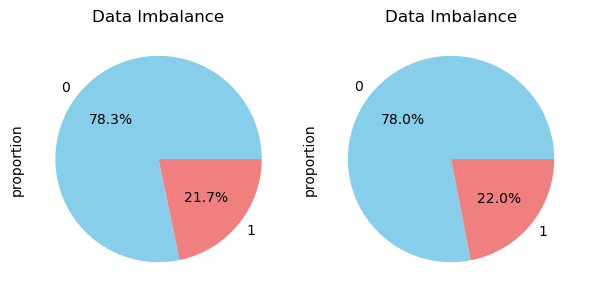

In [93]:
# Check the class distribution in the training set
train_class_distribution = y_train.value_counts(normalize=True)

# Check the class distribution in the validation set
val_class_distribution = y_test.value_counts(normalize=True)

# Plotting pie charts
plt.figure(figsize=(6, 3))

# Training set class distribution pie chart
plt.subplot(1, 2, 1)
train_class_distribution.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], labels=['0', '1'])
plt.title('Data Imbalance')

# Validation set class distribution pie chart
plt.subplot(1, 2, 2)
val_class_distribution.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], labels=['0', '1'])
plt.title('Data Imbalance')

plt.tight_layout()
plt.show()

In [94]:
# Display the ratio of training data versus validation data
training_data_ratio = len(X_train) / (len(X_train) + len(X_test))
validation_data_ratio = len(X_test) / (len(X_train) + len(X_test))

print(f"Training Data Ratio: {training_data_ratio:.2f}")
print(f"Validation Data Ratio: {validation_data_ratio:.2f}")

Training Data Ratio: 0.90
Validation Data Ratio: 0.10


**Model**

In [95]:
# LGM Model

param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]}
    

# Initialize the LGBMClassifier
lgbm = LGBMClassifier()

# Perform GridSearchCV with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1)
grid_search_lgbm.fit(X_train,y_train)


# Display the best parameters and best score
print("Best parameters for LGBM:", grid_search_lgbm.best_params_)
print("Best accuracy for LGBM:", grid_search_lgbm.best_score_)  

# Use the best parameters to fit the model
best_params = grid_search_lgbm.best_params_
lgbm = LGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)

# Predict using the fitted model
y_pred = lgbm.predict(X_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 2304, number of negative: 640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782609 -> initscore=1.280934
[LightGBM] [Info] Start training from score 1.280934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [96]:
# Correctly instantiate the XGBClassifier with proper parameter names
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6)
lgbm.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score

# Predict using the fitted model
y_pred = lgbm.predict(X_train)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

# Calculate and print accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2304, number of negative: 640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.782609 -> initscore=1.280934
[LightGBM] [Info] Start training from score 1.280934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [97]:
# Get feature importance
feature_importance = lgbm.feature_importances_
feature_names = features.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                                    feature  importance
24             average_days_since_last_loan         793
22                   average_repayment_time         654
6                                       age         561
23               average_loan_duration_days         468
19              total_missed_first_due_date         285
25     average_days_first_due_duration_days         268
16        employment_status_clients_Unknown         186
4                    loan_to_totaldue_ratio         167
18                           avg_loanamount         158
0                                loannumber         131
20                   total_closed_loan_late         110
3                                  totaldue         106
9                 bank_account_type_Savings         101
8                   bank_account_type_Other         100
21                         average_termdays          96
27                      average_is_referred          96
5                    loan_to_termdays_ratio     

Precision: 0.81
Recall: 0.99
F1 Score: 0.89
AUC-ROC: 0.59

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.19      0.31       640
         1.0       0.81      0.99      0.89      2304

    accuracy                           0.81      2944
   macro avg       0.81      0.59      0.60      2944
weighted avg       0.81      0.81      0.77      2944



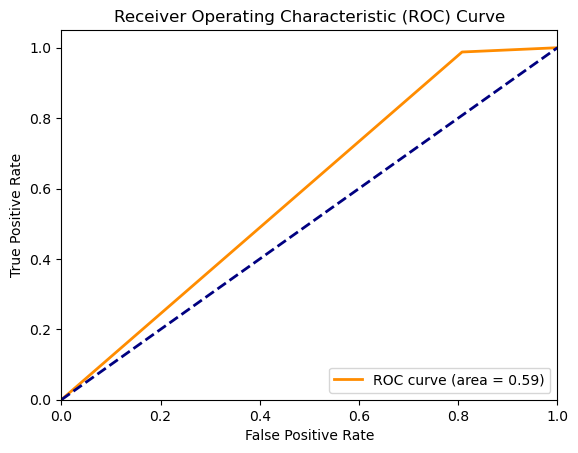

In [98]:
# Calculate evaluation metrics
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
classificationSummary(y_train, y_pred)

Confusion Matrix (Accuracy 0.8149)

       Prediction
Actual    0    1
     0  123  517
     1   28 2276


In [100]:
# Predict on the validation set
y_predicted = lgbm.predict(X_test)


# Calculate and print accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_predicted))



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.8148777173913043
Confusion Matrix:
[[ 10  62]
 [  2 254]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.14      0.24        72
         1.0       0.80      0.99      0.89       256

    accuracy                           0.80       328
   macro avg       0.82      0.57      0.56       328
weighted avg       0.81      0.80      0.75       328



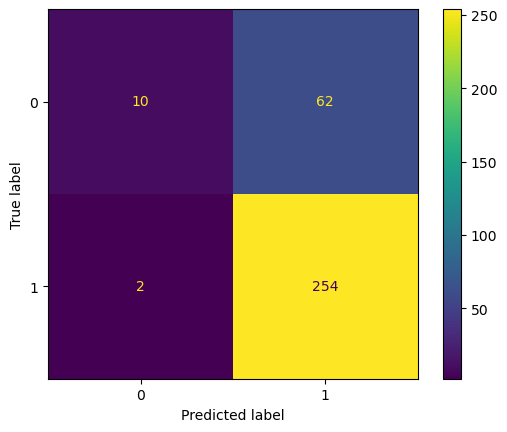

In [101]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()


In [102]:
columns_to_convert = test.columns[5:16]  # Adjusted to Python's 0-based index (includes 6 to 15)

# Convert these columns to 'bool'
for column in columns_to_convert:
    test[column] = test[column].astype(bool)

# Verify the changes
print(test.dtypes)

customerid                                  object
loannumber                                   int64
loanamount                                   int64
termdays                                     int64
totaldue                                   float64
loan_to_totaldue_ratio                        bool
loan_to_termdays_ratio                        bool
age                                           bool
bank_account_type_Current                     bool
bank_account_type_Other                       bool
bank_account_type_Savings                     bool
employment_status_clients_Contract            bool
employment_status_clients_Permanent           bool
employment_status_clients_Retired             bool
employment_status_clients_Self-Employed       bool
employment_status_clients_Student             bool
employment_status_clients_Unemployed          bool
employment_status_clients_Unknown             bool
total_loans                                float64
avg_loanamount                 

Feature Importances:
                                    feature  importance
24             average_days_since_last_loan         793
22                   average_repayment_time         654
6                                       age         561
23               average_loan_duration_days         468
19              total_missed_first_due_date         285
25     average_days_first_due_duration_days         268
16        employment_status_clients_Unknown         186
4                    loan_to_totaldue_ratio         167
18                           avg_loanamount         158
0                                loannumber         131
20                   total_closed_loan_late         110
3                                  totaldue         106
9                 bank_account_type_Savings         101
8                   bank_account_type_Other         100
21                         average_termdays          96
27                      average_is_referred          96
5                    loan_t

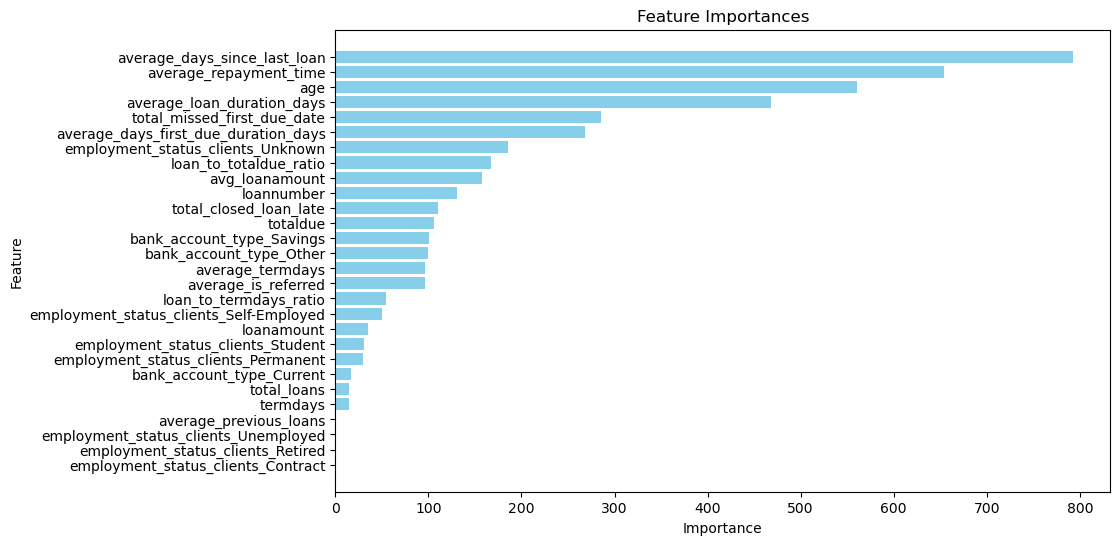

In [103]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [104]:
# Predict on the training set
y_train_pred = lgbm.predict(X_train)

# Correctly predicted instances
correct_predictions = (y_train == y_train_pred)
correct_indices = correct_predictions[correct_predictions].index[:3]  # Get indices of the first 3 correct predictions

# Incorrectly predicted instances
incorrect_predictions = (y_train != y_train_pred)
incorrect_indices = incorrect_predictions[incorrect_predictions].index[:3]  # Get indices of the first 3 incorrect predictions

customer_ids_train = train_org[['customerid']]
customer_ids_val = test_org[['customerid']]


# Display correct predictions
print("Correctly Predicted Instances:")
print(X_train.loc[correct_indices])
print("Customer IDs:", customer_ids_train.loc[correct_indices].values)
print("True Labels:", y_train.loc[correct_indices].values)
print("Predicted Labels:", y_train_pred[correct_indices])

# Display incorrect predictions
print("Incorrectly Predicted Instances:")
print(X_train.loc[incorrect_indices])
print("Customer IDs:", customer_ids_train.loc[incorrect_indices].values)
print("True Labels:", y_train.loc[incorrect_indices].values)
print("Predicted Labels:", y_train_pred[incorrect_indices])


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Correctly Predicted Instances:
      loannumber  loanamount  termdays  totaldue  loan_to_totaldue_ratio  \
879          3.0     10000.0      15.0   11500.0                0.869565   
2723         2.0     10000.0      15.0   11500.0                0.869565   
513          2.0     10000.0      30.0   13000.0                0.769231   

      loan_to_termdays_ratio   age  bank_account_type_Current  \
879               666.666667  50.0                        0.0   
2723              666.666667  42.0                        0.0   
513               333.333333  43.0                        0.0   

      bank_account_type_Other  bank_account_type_Savings  ...  avg_loanamount  \
879                       0.0                        1.0  ...         10000.0   
2723                      0.0                        1.0  ...         10000.0   
513                       1.0 

In [105]:
test_pred = lgbm.predict(testdata)
test_output = test_org[['customerid']]
test_output['Good_Bad_flag'] = test_pred

test_output.rename({'customerid': 'customerID'}, inplace=True, axis =1)
test_output.to_csv('C:\Finance Upgr\Intellx Safe\MMA\869 Machine Learning\Project\Outcome_predictions.csv')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\518148518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_output['Good_Bad_flag'] = test_pred
C:\Users\dany.john\AppData\Local\Temp\ipykernel_16696\518148518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_output.rename({'customerid': 'customerID'}, inplace=True, axis =1)
